# Hotel ID to Combat Human Trafficking

* Samuel Méndez Villegas - A01652277
* Mariana Pérez Carmona - A01731813
* Nancy Lesly Segura - A01734337
* Iker Ledesma Durán - A01653115
* Paul Garcia Morfin - A01750164

***Resumen:*** *Las redes neuronales han sido un gran avance para los modelos de inteligencia artificial, ya que gracias a sus diferentes arquitecturas se pueden resolver desde problemas de regresión, o hasta procesar imágenes, texto, audio e incluso vídeo. Una de las arquitecturas más utilizadas para la clasificación de imágenes es la conocida como red neuronal convolucional, la cual le permite a la computadora aprender o identificar patrones en las imágenes y a partir de ellos asignarles una clase específica. En este cuaderno se trabajará con redes neuronales convolucionales con el objetivo de poder clasificar, dada una imagen de un cuarto de hotel, el hotel al que la imagen corresponde.*

## Base de datos

La base de datos que se utilizará para entrenar y probar el modelo fue obtenida de la competencia de Kaggle "Hotel-ID to Combat Human Trafficking" a la cual se accede desde la siguiente liga: `https://www.kaggle.com/c/hotel-id-to-combat-human-trafficking-2022-fgvc9`. En la base de datos hay un total de 3116 clases distintas. Cada clase contiene un número distinto de imágenes, así que el primer paso que se hará, es visualizar cómo están balanceadas las clases.

## Análisis del balance de las clases

Para analizar el balanceo de las clases, se construirá un diccionario en donde cada llave corresponderá al nombre de la clase, mientras que el valor que guarda, el número de imágenes que contiene. 

In [ ]:
## Dependencias a utilizar
import os 
import errno
import shutil

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import pandas as pd
import random

from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from keras import regularizers
from sklearn.utils import class_weight

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/Shareddrives/Concentracion IA"
!pwd

Mounted at /content/drive
/content/drive/Shareddrives/Concentracion IA
/content/drive/Shareddrives/Concentracion IA


In [ ]:
## Se accede a la carpeta que contiene las imágenes de entrenamiento
carpeta_train = "/Users/sammendez/Desktop/Hotel-Images/train_images"
carpeta_train

'/Users/sammendez/Desktop/Hotel-Images/train_images'

In [ ]:
## Se listan el total de archivos dentro la carpeta principal
carpetas = os.listdir(carpeta_train)

## Se elimina el archivo '.DS_Store' del directorio 
carpetas.remove('.DS_Store')
len(carpetas)

3116

Por alguna razón, siempre que se aplica el comando `os.listdir()` se añade al directorio una carpeta con el nombre de '.DS_Store', por lo que esta se elimina. Como se observa en la última celda de código, el total de clases es de 3116. A continuación se pasará a crear el diccionario que contiene el número de imágenes por clase y se convertirá en un data frame.

In [ ]:
## Se realiza un conteo de cuántas imágenes hay por clase y se guardan en un diccionario
num_imagenes = {}

for carpeta in carpetas:
    contador = 0
    ruta = os.path.join(carpeta_train, carpeta)
    
    with os.scandir(ruta) as ficheros:
        for fichero in ficheros:
            contador += 1
        num_imagenes[carpeta] = contador
        
## Se convierte el diccionario en un data frame
df = pd.DataFrame([[key, num_imagenes[key]] for key in num_imagenes.keys()], columns=['Carpeta', 'Total_Imagenes'])
df

,Carpeta,Total_Imagenes
0,4943,41
1,2872,7
2,25947,4
3,96660,24
4,203609,8
...,...,...
3111,45223,8
3112,197790,12
3113,89607,19
3114,306424,8


Ya teniendo un data frame, es sencillo obtener el número total de imágenes de la base de datos, así como el balanceo de las clases con los comandos `sum()` y `value_counts()` respectivamente.

In [ ]:
## Número total de imágenes
df['Total_Imagenes'].sum()

44703

In [ ]:
## Número de clases con x cantidad de imágenes
df['Total_Imagenes'].value_counts()

8       939
4       452
12      352
7       145
16      140
       ... 
70        1
68        1
62        1
54        1
1393      1
Name: Total_Imagenes, Length: 88, dtype: int64

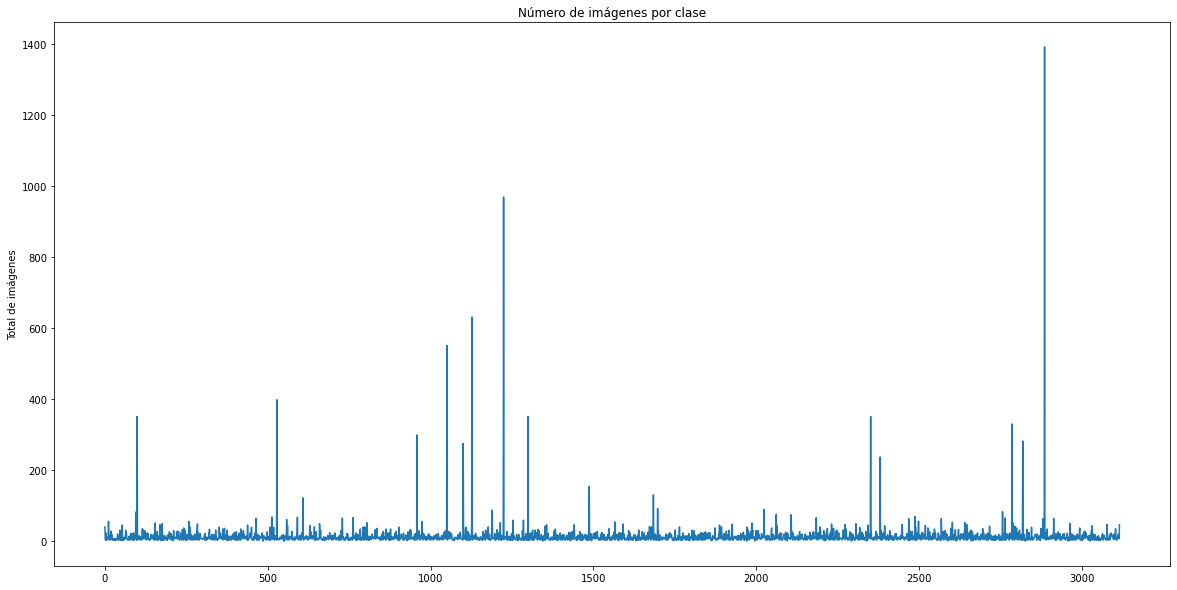

In [ ]:
x = []
for key in num_imagenes:
    x.append(num_imagenes[key])

plt.figure(figsize = (20, 10))
plt.plot(x)
plt.title('Número de imágenes por clase')
plt.ylabel('Total de imágenes')
plt.show()

Como se puede observar, las clases están muy desbalanceadas, dado a que existe una gran diferencia entre el número de imágenes entre una clase y otra. 

De igual forma, se puede obtener un resumen estadístico del número de imágenes por clase con el comando `describe()`.

In [ ]:
df.describe()

,Total_Imagenes
count,3116.000000
mean,14.346277
std,38.889197
min,1.000000
25%,8.000000
50%,8.000000
75%,15.000000
max,1393.000000


Gracias al anterior resumen, se observa que el promedio de imágenes por clase es de 14. Sin embargo hay un directorio con 1393 observaciones, mientras que el mínimo es de una imagen.

## Preprocesamiento de las imágenes

Es bien sabido para que una red neuronal convolucional tenga un buen desempeño y no presente un sobreajuste, es necesario que las clases estén lo más balanceadas posible, ya que así se reduce el clasificar erroneamente las clases con menos observaciones.

Anteriormente, comprobamos que hay un desbalanceo entre las clases, por lo que se pasará a balancearlas. Sin embargo, antes de esto, se identificó que hay varias clases que contienen una sola imagen. Es más que claro que con una sola imagen no se puede realizar grandes cosas, por lo que se decidió eliminar de la base de datos estos directorios. 

In [ ]:
## Copia de seguridad de las clases con una sola imagen (11 en total)
carpeta_resguardo = "/Users/sammendez/Desktop/Hotel-ID/resguardo_clases_chicas"

for carpeta in carpetas:
    temp_dir = os.path.join(carpeta_train, carpeta)
    img_names = [os.path.join(temp_dir, name) for name in os.listdir(temp_dir)]
    
    if len(img_names) == 1:
        sampled_images = random.sample(img_names, k = len(img_names))
    else: 
        continue

    carpeta_destino = os.path.join(carpeta_resguardo, carpeta)
    
    try:
        os.mkdir(carpeta_destino)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
        
    for imagen in sampled_images:
        shutil.copy(imagen, carpeta_destino)

In [ ]:
## Se muestran las carpetas con una sola imagen 
df.loc[df['Total_Imagenes'] == 1]

,Carpeta,Total_Imagenes
485,310041,1
550,18718,1
551,1122,1
1345,82686,1
1971,95159,1
1996,13132,1
2292,12414,1
2339,35677,1
2613,396607,1
2825,93959,1


In [ ]:
## Se eliminan aquellos directorios que contienen una sola imagen
base = "/Users/sammendez/Desktop/Hotel-Images/train_images"

for carpeta in num_imagenes:
    if num_imagenes[carpeta] == 1:
        ruta_carpeta = os.path.join(base, carpeta)
        shutil.rmtree(ruta_carpeta)

Para realizar el balanceo de las clases se utilizarán dos métodos, siendo estos 'Data Augmentation' y 'Submuestreo'. La primer técnica permite crecer el número de imágenes de las clases aplicándoles rotaciones, giros y desplazamientos, para de esta manera formar nuevas imágenes a partir de otras. Por otro lado, el submuestreo consiste en tomar una muestra del total de imágenes que hay una clase. 

Aplicando estos dos métodos se logrará obtener un balanceo entre las clases, es decir para las clases con pocas imágenes se le aplicará data augmentation para tener así más observaciones, mientras que para las clases con una cantidad considerable de imágenes, se realizará un submuestreo y se trajará con éste. 

Finalmente, cabe mencionar que el número de imágenes por clase que se definió fue de 14, ya que este fue el promedio de imágenes por clase. De igual forma el tener más registros por directorio puede llegar a elevar mucho el uso de recursos computacionales a la hora de entrenar los modelos, por lo que un número pequeño de imágenes para tantas clases es adecuado.

### Submuestreo de las clases

A continuación se muestran dos celdas de código. En la primera se está generando una copia de seguridad de las carpetas que cumplen con la característica de tener más de 14 imágenes. Esto es con el objetivo de que si se quieren realizar modificaciones posteriormente se pueda tener de vuelta los datos originales.

En la segunda celda se realiza el submuestreo de las clases y se eliminan las imágenes que no forman parte de dicho submuestreo del directorio. 

In [ ]:
## Copia de seguridad de las clases con más de 14 imágenes (794 en total)
carpeta_resguardo = "/Users/sammendez/Desktop/Hotel-ID/resguardo_clases_grandes"

for carpeta in carpetas:
    temp_dir = os.path.join(carpeta_train, carpeta)
    img_names = [os.path.join(temp_dir, name) for name in os.listdir(temp_dir)]
    
    if len(img_names) > 14:
        sampled_images = random.sample(img_names, k = len(img_names))
    else: 
        continue

    carpeta_destino = os.path.join(carpeta_resguardo, carpeta)
    
    try:
        os.mkdir(carpeta_destino)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
        
    for imagen in sampled_images:
        shutil.copy(imagen, carpeta_destino)

In [ ]:
## Se realiza el sampling de las clases
carpetas = os.listdir(carpeta_train)
carpetas.remove('.DS_Store') 

for carpeta in carpetas:
    temp_dir = os.path.join(carpeta_train, carpeta)
    img_names = [os.path.join(temp_dir, name) for name in os.listdir(temp_dir)]
    
    if len(img_names) > 14:
        sampled_images = random.sample(img_names, k=14)
        
        for imagen in img_names:
            if imagen not in sampled_images:
                os.remove(imagen)
    else: 
        continue

### Data Augmentation

A continución se muestra el código utilizado para aumentar el número de imágenes de las clases con menos observaciones.

In [ ]:
## Algunas dependencias que se necesitan
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from random import sample

In [ ]:
## Se crea el objeto 'ImageDataGenerator' en el cual se especifica las trasnformaciones que se aplicarán
base_dir = '/Users/sammendez/Desktop/Hotel-ID'
carpeta_train = os.path.join(base_dir,'train_images')

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [ ]:
## Se realiza como tal el data augmentation
carpetas = os.listdir(carpeta_train)
carpetas.remove('.DS_Store')

for carpeta in carpetas:
    temp_dir = os.path.join(carpeta_train, carpeta)
    img_names = [os.path.join(temp_dir, name) for name in os.listdir(temp_dir)]
    
    if len(img_names) <= 7:
        target_number = 14
    else: 
        continue
        
    remainder = sample(img_names, k=target_number % len(img_names))   
    target_per_img = target_number // len(img_names) - 1
    i, j, k = 0, 0, 0

    for img_path in img_names:
        img = tf.keras.preprocessing.image.load_img(img_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        for batch in train_datagen.flow(img_array, batch_size=1):
            temp = tf.keras.preprocessing.image.array_to_img(batch[0])
            zeros = 9 - len(str(i + 1))
            name = zeros * '0' + str(i + 1) + 'CREADA'
            name = os.path.join(temp_dir, name + '.jpg')
            temp.save(name)
            i += 1
            if img_path in remainder:
                j += 1
                if j == (target_per_img + 1):
                    j = 0
                    break
            elif img_path not in remainder:
                k += 1
                if k == target_per_img:
                    k = 0
                    break

De igual forma, en caso de que se quiera realizar posteriormente más ajustes sobre el aumento de las clases, se creó una función la cual permite eliminar las imágenes generadas anteriormente. Lo que realiza es buscar aquellos archivos qe tengan en el nombre la palabra 'CREADA' y posteriormente la elimina.  

In [ ]:
## ELIMINACIÓN DE LAS IMÁGENES CREADAS CON DATA AUMENTATION
def eliminar_creaciones(carpeta_train):
    carpetas = os.listdir(carpeta_train)
    carpetas.remove('.DS_Store') 
    
    for carpeta in carpetas:
        ruta = os.path.join(carpeta_train, carpeta)
        
        imagenes = []
        
        with os.scandir(ruta) as ficheros:
            for fichero in ficheros:
                imagenes.append(fichero.name)
                
        for imagen in imagenes:
            if 'CREADA' in imagen:
                ruta_imagen = os.path.join(ruta, imagen)
                os.remove(ruta_imagen)
    return print('************************\n Imágenes eliminadas \n************************')

In [ ]:
# eliminar_creaciones(carpeta_train)

### Análisis del nuevo balanceo de clases. 

Una vez aplicado el submuestreo y el data augmentation, veamos cómo quedaron balanceadas las clases. Para esto se vuelve a ejecutar parte del código anterior:

In [ ]:
carpeta_train = "/Users/sammendez/Desktop/Hotel-ID/train_images1"
carpeta_train

'/Users/sammendez/Desktop/Hotel-ID/train_images1'

In [ ]:
## Se listan el total de archivos dentro la carpeta principal
carpetas = os.listdir(carpeta_train)

## Se elimina el archivo '.DS_Store' del directorio 
carpetas.remove('.DS_Store')
len(carpetas)

3105

In [ ]:
## Se realiza un conteo de cuántas imágenes hay por clase y se guardan en un diccionario
num_imagenes = {}

for carpeta in carpetas:
    contador = 0
    ruta = os.path.join(carpeta_train, carpeta)
    
    with os.scandir(ruta) as ficheros:
        for fichero in ficheros:
            contador += 1
        num_imagenes[carpeta] = contador
        
## Se convierte el diccionario en un data frame
df_2 = pd.DataFrame([[key, num_imagenes[key]] for key in num_imagenes.keys()], columns=['Carpeta', 'Total_Imagenes'])
df_2

,Carpeta,Total_Imagenes
0,4943,14
1,2872,14
2,25947,14
3,96660,14
4,203609,8
...,...,...
3100,45223,8
3101,197790,12
3102,89607,14
3103,306424,8


In [ ]:
## Número total de imágenes
df_2['Total_Imagenes'].sum()

36443

In [ ]:
## Número de clases con x cantidad de imágenes
df_2['Total_Imagenes'].value_counts()

14    1595
8      939
12     352
11      69
10      64
13      51
9       35
Name: Total_Imagenes, dtype: int64

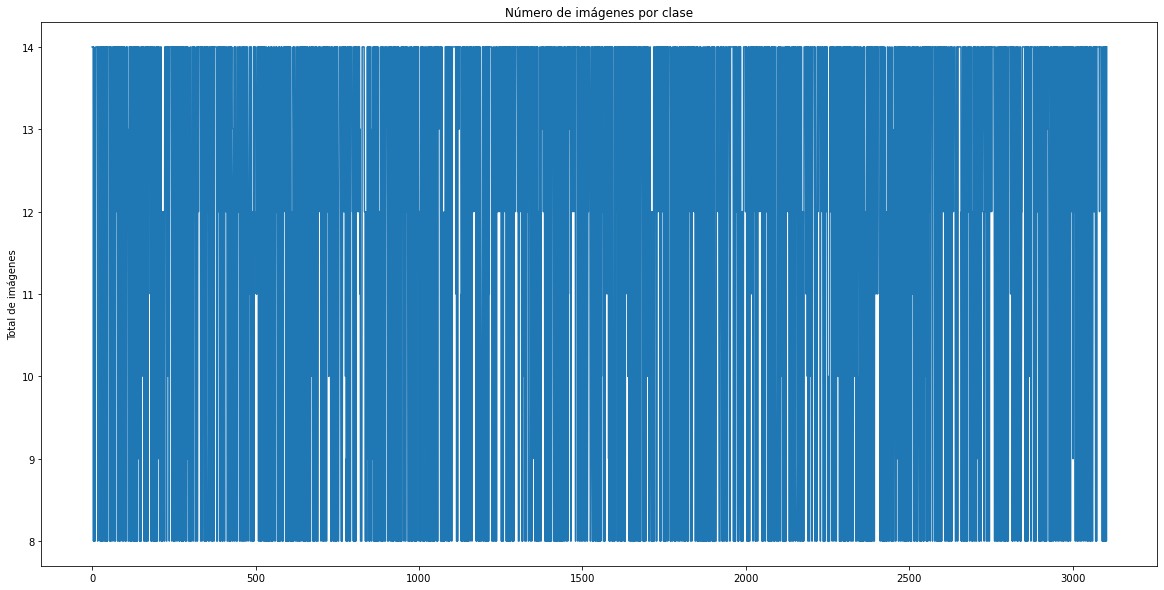

In [ ]:
x = []
for key in num_imagenes:
    x.append(num_imagenes[key])

plt.figure(figsize = (20, 10))
plt.plot(x)
plt.title('Número de imágenes por clase')
plt.ylabel('Total de imágenes')
plt.show()

Se puede observar que no se tiene un balance perfecto, es decir que no todas las clases tienen el mismo número de imágenes, pero si están muchísimo más balanceadas que los datos orignales, ya que logramos acotar todas las clases a que estén en el rango entre 8 y 14 imágenes.

## Split en train y validation

Una vez balanceadas las clases, se tiene que crear un conjunto de validación, dado a que solamente se tiene una carpeta con imágenes de entrenamiento. Para esto, se generará un split de la carpeta de entrenamiento en donde se seleccionará aleatoriamente por clase una proporción de imágenes y están se moveran a su carpeta correspondiente en el conjunto de validación.

Lo explicado anteriormente se logra con las siguientes funciones generadas, en donde de igual forma se creó una función que devuelve todo a su estado original. Para ejecutarlas únicamente se debe de especificar la ruta de acceso de la carpeta de entrenamiento, y la ruta de acceso de la carpeta de validación, la cual de momento es una carpeta vacia. 

A grandes rasgos, el split se realiza de la siguiente forma:
* Se recorre cada una de las clases dentro del set de entrenamiento
* Por cada clase, se calcula el número total de imágenes y se realiza un cálculo con la proporción especificada con el objetivo para obtener el número de imágenes que se moverán al set de validación.
* Se escoge aleatoriamente las imágenes que se moverán al set de validación y se mueven.

In [ ]:
def selectRandom(num_imagenes_validacion, imagenes):
    '''
    Selecciona aleatoriamente las imágenes a mover de la carpeta de entrenamiento a su respectiva carpeta de 
    validación.
    
    INPUT:
    num_imagenes_validacion: numero total de imagenes a mover a la carpeta de validacion correspondiente.
    imagenes: lista con el nombre de todas las imagenes contenidas en la carpeta respectiva.
    
    OUTPUT:
    imagenes_validacion_seleccionadas: lista con el nombre de la imágenes seleccionadas aleatoriamente
    imagenes: lista con el nombre de las imágenes que serán de entrenamiento
    '''
    
    imagenes_validacion_seleccionadas = []
    
    for i in range(int(num_imagenes_validacion)):
        imagen_seleccionada = random.choice(imagenes)
        imagenes_validacion_seleccionadas.append(imagen_seleccionada)
        ## Se elimina para asegurar que no se repita la imagen
        imagenes.remove(imagen_seleccionada)
        
    return imagenes_validacion_seleccionadas, imagenes

In [ ]:
def estado_original(carpeta_train, carpeta_validation):
    '''
    Restablece el split a su estado original, es decir devuelve las imágenes de las carpetas de validación a su 
    respectiva carpeta de entrenamiento con el objetivo de realizar un nuevo split.
    
    carpeta_train: ruta de la carpeta de entrenamiento 
    carpeta_validacion: ruta de la carpeta de validacion
    '''
    carpeta_val = os.listdir(carpeta_validation)
    #carpeta_val.remove('.DS_Store')
    
    for carpeta in carpeta_val:
        ruta = os.path.join(carpeta_validation, carpeta)
        
        imagenes = []
        with os.scandir(ruta) as ficheros:
            for fichero in ficheros:
                imagenes.append(fichero.name)
    
        carpeta_destino = os.path.join(carpeta_train, carpeta)

        for imagen in imagenes:
            origen = os.path.join(ruta, imagen)
            shutil.move(origen, carpeta_destino)
    
    return print('************************\n Archivos restablecidos\n************************')

In [ ]:
def train_validation_split(proporcion, carpeta_train, carpeta_validation):
    '''
    Realiza la separacion del conjunto total de entrenamiento, en entrenamiento y validación de acuerdo a una
    proporcion dada.
    
    INPUT:
    proporcion: proporcion del conjunto de validacion que se desea.
    carpeta_train: ruta de la carpeta de entrenamiento.
    carpeta_validation: ruta de la carpeta de validación.
    '''
    ## Antes de hacer el split, se devulven todos las imagenes a su correspondiente carpeta de entrenamiento
    estado_original(carpeta_train, carpeta_validation)
    
    carpetas = os.listdir(carpeta_train)
    carpetas.remove('.DS_Store') 
    
    for carpeta in carpetas:
        ruta = os.path.join(carpeta_train, carpeta)
    
        imagenes = []

        with os.scandir(ruta) as ficheros:
            for fichero in ficheros:
                imagenes.append(fichero.name)
    
        num_imagenes_validacion = np.floor(len(imagenes) * proporcion)
    
        imagenes_validacion_seleccionadas, imagenes = selectRandom(num_imagenes_validacion, imagenes)
    
        carpeta_destino = os.path.join(carpeta_validation, carpeta)
    
        try:
            os.mkdir(carpeta_destino)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
    
        for imagen in imagenes_validacion_seleccionadas:
            origen = os.path.join(ruta, imagen)
            shutil.move(origen, carpeta_destino)
        
    return print('************************\n Split realizado \n************************')

In [ ]:
proporcion = 0.3
carpeta_train = '/Users/sammendez/Desktop/Hotel-ID/train_images1'
carpeta_validation = '/Users/sammendez/Desktop/Hotel-ID/validation_images1'

In [ ]:
train_validation_split(proporcion, carpeta_train, carpeta_validation)

************************
 Archivos restablecidos
************************
************************
 Split realizado 
************************


In [ ]:
#estado_original(carpeta_train, carpeta_validation)

************************
 Archivos restablecidos
************************


## Construcción de modelos

Ya teniendo separados los datos en set de entrenamiento y de validación se pasará a implementar diferentes arquitecturas de redes neuronales convolucionales. El objetivo de la red es poder clasificar una imagen en la clase correcta. En las siguientes celdas de código se muestra la aplicación de los modelos.

In [ ]:
## 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
## Se define el tamaño de las imágenes, así como el tamaño del batch del set de entrenamiento
train_generator = train_datagen.flow_from_directory(carpeta_train, 
                                                    target_size = (28, 28),
                                                    batch_size=13,
                                                    save_format='jpg')

Found 26507 images belonging to 3105 classes.


In [ ]:
## Se define el tamaño de las imágenes, así como el tamaño del batch del set de validación
validation_generator = validation_datagen.flow_from_directory(carpeta_validation,
                                                    target_size = (28,28),
                                                    batch_size=12,
                                                    save_format='jpg')

Found 9936 images belonging to 3105 classes.


### Primer modelo

En primer lugar, se generó un modelo bastante simple, el cual contiene una capa convolucional, una capa de pooling, una capa de normalización del batch, una Flatten y dos capas densas.

In [ ]:
## Generación del modelo
model = models.Sequential([
                          Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3),kernel_initializer='he_uniform'), 
                          MaxPooling2D((2, 2)),
                          BatchNormalization(),
                          Flatten(), 
                          Dense(1000, activation='relu',kernel_initializer='he_uniform'), 
                          BatchNormalization(),
                          Dense(3105, activation='softmax')
                          ])

In [ ]:
## Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 32)       128       
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 1000)              5409000   
                                                                 
 batch_normalization_1 (Batc  (None, 1000)             4

In [ ]:
## Se compila el modelo y se define la métrica de evaluación a utilizar
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=150)
model.compile(loss='CategoricalCrossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=metric)

In [ ]:
## Se realiza el entrenamiento del modelo
history = model.fit(train_generator, steps_per_epoch=100, epochs=50, validation_data=validation_generator, validation_steps=100)

Epoch 1/50
100/100 [==============================] - 164s 2s/step - loss: 8.4307 - top_k_categorical_accuracy: 0.0592 - val_loss: 8.3075 - val_top_k_categorical_accuracy: 0.0625
Epoch 2/50
100/100 [==============================] - 155s 2s/step - loss: 8.2435 - top_k_categorical_accuracy: 0.1131 - val_loss: 8.1295 - val_top_k_categorical_accuracy: 0.0833
Epoch 3/50
100/100 [==============================] - 147s 1s/step - loss: 7.9428 - top_k_categorical_accuracy: 0.1654 - val_loss: 8.4813 - val_top_k_categorical_accuracy: 0.0908
Epoch 4/50
100/100 [==============================] - 145s 1s/step - loss: 7.6153 - top_k_categorical_accuracy: 0.2408 - val_loss: 8.5386 - val_top_k_categorical_accuracy: 0.1042
Epoch 5/50
100/100 [==============================] - 147s 1s/step - loss: 7.4189 - top_k_categorical_accuracy: 0.2700 - val_loss: 8.4461 - val_top_k_categorical_accuracy: 0.1175
Epoch 6/50
100/100 [==============================] - 150s 2s/step - loss: 7.2278 - top_k_categorical_acc

100/100 [==============================] - 148s 1s/step - loss: 2.0844 - top_k_categorical_accuracy: 0.8892 - val_loss: 9.4321 - val_top_k_categorical_accuracy: 0.1950
Epoch 47/50
100/100 [==============================] - 151s 2s/step - loss: 1.8187 - top_k_categorical_accuracy: 0.8931 - val_loss: 8.9381 - val_top_k_categorical_accuracy: 0.2200
Epoch 48/50
100/100 [==============================] - 149s 1s/step - loss: 1.5951 - top_k_categorical_accuracy: 0.9131 - val_loss: 9.0975 - val_top_k_categorical_accuracy: 0.2158
Epoch 49/50
100/100 [==============================] - 147s 1s/step - loss: 1.6052 - top_k_categorical_accuracy: 0.9100 - val_loss: 9.3961 - val_top_k_categorical_accuracy: 0.2017
Epoch 50/50
100/100 [==============================] - 152s 2s/step - loss: 1.6601 - top_k_categorical_accuracy: 0.9123 - val_loss: 8.8604 - val_top_k_categorical_accuracy: 0.2050


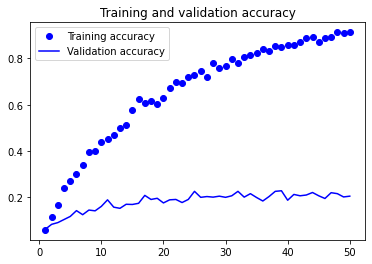

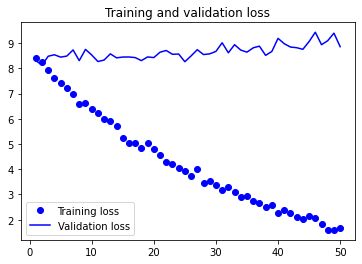

In [ ]:
acc = history.history['top_k_categorical_accuracy']
val_acc = history.history['val_top_k_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Segundo modelo

Como se pudo observar, el primer modelo construido no tuvo los mejores resultados, ya que además de presentar valores bajos en el accuracy, presentó un sobre ajuste, ya que se tuve un mucho menor rendimiento con el set de validación que con el set de entrenamiento. 

Debido a lo anterior, se generó un nuevo modelo, pero a este se le incluyó un regularizador.

In [ ]:
## 
model2 = models.Sequential([
                          Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3),kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(l=0.01)), 
                          MaxPooling2D((2, 2)),
                          BatchNormalization(),
                          Flatten(),
                          Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l=0.1)), 
                          BatchNormalization(),
                          Dense(3105, activation='softmax')
                          ])

In [ ]:
##
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               2769408   
                                                                 
 batch_normalization_3 (Batc  (None, 512)             

In [ ]:
## 
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=150)
model2.compile(loss='CategoricalCrossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=metric)

In [ ]:
history = model2.fit(train_generator, steps_per_epoch=100, epochs=50, validation_data=validation_generator, validation_steps=80)

Epoch 1/50
100/100 [==============================] - 138s 1s/step - loss: 38.1410 - top_k_categorical_accuracy: 0.0600 - val_loss: 11.9277 - val_top_k_categorical_accuracy: 0.0562
Epoch 2/50
100/100 [==============================] - 133s 1s/step - loss: 11.6120 - top_k_categorical_accuracy: 0.0862 - val_loss: 11.3745 - val_top_k_categorical_accuracy: 0.0896
Epoch 3/50
100/100 [==============================] - 120s 1s/step - loss: 11.4694 - top_k_categorical_accuracy: 0.0877 - val_loss: 11.5710 - val_top_k_categorical_accuracy: 0.0698
Epoch 4/50
100/100 [==============================] - 94s 940ms/step - loss: 11.7062 - top_k_categorical_accuracy: 0.0946 - val_loss: 11.7499 - val_top_k_categorical_accuracy: 0.0677
Epoch 5/50
100/100 [==============================] - 93s 931ms/step - loss: 11.3874 - top_k_categorical_accuracy: 0.0977 - val_loss: 12.6172 - val_top_k_categorical_accuracy: 0.0667
Epoch 6/50
100/100 [==============================] - 98s 985ms/step - loss: 10.8844 - top_

Epoch 46/50
100/100 [==============================] - 94s 947ms/step - loss: 8.4462 - top_k_categorical_accuracy: 0.1885 - val_loss: 9.1558 - val_top_k_categorical_accuracy: 0.1010
Epoch 47/50
100/100 [==============================] - 95s 958ms/step - loss: 8.3323 - top_k_categorical_accuracy: 0.2300 - val_loss: 8.6043 - val_top_k_categorical_accuracy: 0.1594
Epoch 48/50
100/100 [==============================] - 95s 953ms/step - loss: 8.3104 - top_k_categorical_accuracy: 0.2246 - val_loss: 8.8814 - val_top_k_categorical_accuracy: 0.1333
Epoch 49/50
100/100 [==============================] - 97s 970ms/step - loss: 8.2456 - top_k_categorical_accuracy: 0.2523 - val_loss: 8.6809 - val_top_k_categorical_accuracy: 0.1542
Epoch 50/50
100/100 [==============================] - 94s 949ms/step - loss: 8.3743 - top_k_categorical_accuracy: 0.2215 - val_loss: 8.9771 - val_top_k_categorical_accuracy: 0.0990


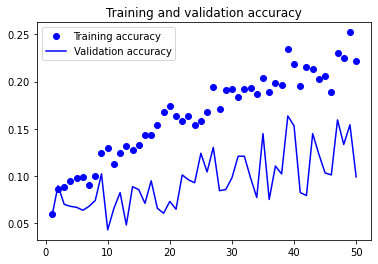

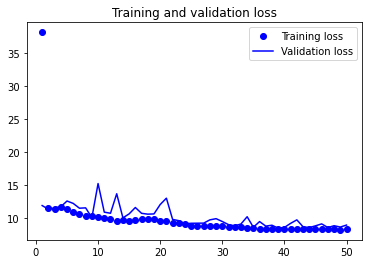

In [ ]:
acc = history.history['top_k_categorical_accuracy']
val_acc = history.history['val_top_k_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Tercer modelo

En este modelo se añadieron capas de dropout, dado a que en los anteriores modelos se había obtenido un sobre ajuste de los datos.

In [ ]:
## 
model3 = models.Sequential([
                          Conv2D(32, (2, 2), activation='relu', input_shape=(28, 28, 3),kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l=0.01)), 
                          MaxPooling2D((2, 2)),
                          Dropout(0.4),
                          BatchNormalization(),
                          Flatten(), 
                          Dense(5, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l=0.01)), 
                          Dropout(0.2),
                          Dense(3105, activation='softmax')
                          ])

In [ ]:
##
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 27, 27, 32)        416       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                

In [ ]:
## 
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=150)
model3.compile(loss='CategoricalCrossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=metric)

In [ ]:
history = model3.fit(train_generator, steps_per_epoch=100, epochs=50, validation_data=validation_generator, validation_steps=80)

Epoch 1/50
100/100 [==============================] - 94s 941ms/step - loss: 8.7027 - top_k_categorical_accuracy: 0.0477 - val_loss: 8.5793 - val_top_k_categorical_accuracy: 0.0521
Epoch 2/50
100/100 [==============================] - 95s 957ms/step - loss: 8.4888 - top_k_categorical_accuracy: 0.0438 - val_loss: 8.4040 - val_top_k_categorical_accuracy: 0.0615
Epoch 3/50
100/100 [==============================] - 96s 958ms/step - loss: 8.3422 - top_k_categorical_accuracy: 0.0508 - val_loss: 8.2862 - val_top_k_categorical_accuracy: 0.0573
Epoch 4/50
100/100 [==============================] - 93s 933ms/step - loss: 8.2432 - top_k_categorical_accuracy: 0.0469 - val_loss: 8.2088 - val_top_k_categorical_accuracy: 0.0531
Epoch 5/50
100/100 [==============================] - 96s 960ms/step - loss: 8.1783 - top_k_categorical_accuracy: 0.0577 - val_loss: 8.1537 - val_top_k_categorical_accuracy: 0.0615
Epoch 6/50
100/100 [==============================] - 100s 1s/step - loss: 8.1339 - top_k_categ

100/100 [==============================] - 92s 921ms/step - loss: 7.9240 - top_k_categorical_accuracy: 0.1008 - val_loss: 8.0430 - val_top_k_categorical_accuracy: 0.0865
Epoch 47/50
100/100 [==============================] - 91s 918ms/step - loss: 7.9245 - top_k_categorical_accuracy: 0.1038 - val_loss: 8.0380 - val_top_k_categorical_accuracy: 0.0760
Epoch 48/50
100/100 [==============================] - 91s 914ms/step - loss: 7.9379 - top_k_categorical_accuracy: 0.0962 - val_loss: 7.9274 - val_top_k_categorical_accuracy: 0.1083
Epoch 49/50
100/100 [==============================] - 93s 931ms/step - loss: 7.9305 - top_k_categorical_accuracy: 0.1092 - val_loss: 7.9314 - val_top_k_categorical_accuracy: 0.0979
Epoch 50/50
100/100 [==============================] - 112s 1s/step - loss: 7.9373 - top_k_categorical_accuracy: 0.0869 - val_loss: 7.9197 - val_top_k_categorical_accuracy: 0.1104


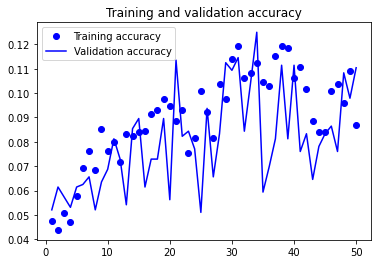

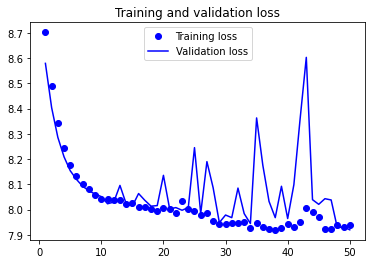

In [ ]:
acc = history.history['top_k_categorical_accuracy']
val_acc = history.history['val_top_k_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Probando otro preprocesamiento de las imágenes - Submuestro de 50 imágenes

Anteriormente se probaron 3 modelos distintos en los cuáles se pudo observar que no dan los mejores resultados si es el 'top k categorical accuracy' la métrica que se toma en cuenta. De igual forma estos resultados se pueden deber al gran número de clases que se tienen (en total 3105). Por lo tanto, ahora se recuperará la base de datos de imágenes original, es decir se eliminarán las imágenes creadas con el data aumentation, así como el submuestreo realizado. Esto es con el objetivo de probar con un número menor de clases. Como equipo se decidió probar con solamente aquellas clases que tuvieran arriba de 50 imágenes y hacer un submuestreo de 50, es decir tener las clases balanceadas a 50 observaciones. Posteriormente se aplicaron técnicas previas para obtener 56 clases con 110 imágenes cada una.

In [ ]:
## Se establece la ruta en donde se tiene las imágenes originales
carpeta_train = "/Users/sammendez/Desktop/Hotel-Images/train_images"
carpeta_train

'/Users/sammendez/Desktop/Hotel-Images/train_images'

In [ ]:
## Se listan el total de archivos dentro la carpeta principal
carpetas = os.listdir(carpeta_train)

## Se elimina el archivo '.DS_Store' del directorio 
#carpetas.remove('.DS_Store')
len(carpetas)

3116

En el resultado de la celda anterior, se muestra que volvemos a tener las 3116 clases originales, sin embargo ahora se pasará a eliminar todos aquellos directorios con menos de 50 imágenes.

In [ ]:
## Se comprueba que las clases están totalmente balanceadas
## Se realiza un conteo de cuántas imágenes hay por clase y se guardan en un diccionario
num_imagenes = {}

for carpeta in carpetas:
    contador = 0
    ruta = os.path.join(carpeta_train, carpeta)
    
    with os.scandir(ruta) as ficheros:
        for fichero in ficheros:
            contador += 1
        num_imagenes[carpeta] = contador
        
## Se convierte el diccionario en un data frame
df_3 = pd.DataFrame([[key, num_imagenes[key]] for key in num_imagenes.keys()], columns=['Carpeta', 'Total_Imagenes'])
df_3

,Carpeta,Total_Imagenes
0,4943,41
1,2872,7
2,25947,4
3,96660,24
4,203609,8
...,...,...
3111,45223,8
3112,197790,12
3113,89607,19
3114,306424,8


In [ ]:
## Se eliminan aquellos directorios que contienen menos de 50 imágenes
base = "/Users/sammendez/Desktop/Hotel-Images/train_images"

for carpeta in num_imagenes:
    if num_imagenes[carpeta] < 50:
        ruta_carpeta = os.path.join(base, carpeta)
        shutil.rmtree(ruta_carpeta)

In [ ]:
## Se realiza el sampling de 50 imágenes de las clases
carpetas = os.listdir(carpeta_train)
carpetas.remove('.DS_Store') 

for carpeta in carpetas:
    temp_dir = os.path.join(carpeta_train, carpeta)
    img_names = [os.path.join(temp_dir, name) for name in os.listdir(temp_dir)]
    
    if len(img_names) > 50:
        sampled_images = random.sample(img_names, k=50)
        
        for imagen in img_names:
            if imagen not in sampled_images:
                os.remove(imagen)
    else: 
        continue

In [ ]:
## Se comprueba que las clases están totalmente balanceadas
## Se realiza un conteo de cuántas imágenes hay por clase y se guardan en un diccionario
num_imagenes = {}

for carpeta in carpetas:
    contador = 0
    ruta = os.path.join(carpeta_train, carpeta)
    
    with os.scandir(ruta) as ficheros:
        for fichero in ficheros:
            contador += 1
        num_imagenes[carpeta] = contador
        
## Se convierte el diccionario en un data frame
df_4 = pd.DataFrame([[key, num_imagenes[key]] for key in num_imagenes.keys()], columns=['Carpeta', 'Total_Imagenes'])
df_4

,Carpeta,Total_Imagenes
0,92039,50
1,95488,50
2,205557,50
3,75667,50
4,127242,50
5,23283,50
6,103150,50
7,5525,50
8,688864,50
9,10129,50


In [ ]:
## Número total de imágenes
df_4['Total_Imagenes'].sum()

2800

In [ ]:
df_4['Total_Imagenes'].value_counts()

50    56
Name: Total_Imagenes, dtype: int64

## Nuevos modelos

Ya con este ajuste realizado, ahora si se pueden probar nuevamente los modelos, o de igual forma crear nuevos para ver si se obtiene alguno que clasifique correctamente las imágenes. 

In [ ]:
## Se realiza el split de los datos en carpeta de train y validación
proporcion = 0.2
carpeta_train = "/content/drive/Shareddrives/Concentracion IA/train_images_50s"
carpeta_validation = "/content/drive/Shareddrives/Concentracion IA/validation_images_50s"

In [ ]:
#train_validation_split(proporcion, carpeta_train, carpeta_validation)

************************
 Archivos restablecidos
************************
************************
 Split realizado 
************************


In [ ]:
## 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
## Se define el tamaño de las imágenes, así como el tamaño del batch del set de entrenamiento
train_generator = train_datagen.flow_from_directory(carpeta_train, 
                                                    target_size = (28, 28),
                                                    batch_size=12,
                                                    save_format='jpg')

Found 4932 images belonging to 56 classes.


In [ ]:
## Se define el tamaño de las imágenes, así como el tamaño del batch del set de validación
validation_generator = validation_datagen.flow_from_directory(carpeta_validation,
                                                    target_size = (28,28),
                                                    batch_size=11,
                                                    save_format='jpg')

Found 1232 images belonging to 56 classes.


### Modelo Uno

Se repiten la mayoría de los parámetros utilizados con el primer set de datos.

In [ ]:
## 
model = models.Sequential([
                          Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3),kernel_initializer='he_uniform'), 
                          MaxPooling2D((2, 2)),
                          BatchNormalization(),
                          Flatten(), 
                          Dense(1000, activation='relu',kernel_initializer='he_uniform'), 
                          BatchNormalization(),
                          Dense(56, activation='softmax')
                          ])

In [ ]:
##
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 32)       128       
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 1000)              5409000   
                                                                 
 batch_normalization_1 (Batc  (None, 1000)             4

In [ ]:
## 
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
model.compile(loss='CategoricalCrossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=[metric,'acc'])

In [ ]:
history = model.fit(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=100)

Epoch 1/50
100/100 [==============================] - 1260s 13s/step - loss: 5.9496 - top_k_categorical_accuracy: 0.2117 - acc: 0.0742 - val_loss: 6.7213 - val_top_k_categorical_accuracy: 0.1400 - val_acc: 0.0318
Epoch 2/50
100/100 [==============================] - 602s 6s/step - loss: 5.0495 - top_k_categorical_accuracy: 0.3150 - acc: 0.1308 - val_loss: 8.6308 - val_top_k_categorical_accuracy: 0.1373 - val_acc: 0.0400
Epoch 3/50
100/100 [==============================] - 450s 5s/step - loss: 4.1594 - top_k_categorical_accuracy: 0.4475 - acc: 0.2250 - val_loss: 13.6812 - val_top_k_categorical_accuracy: 0.1473 - val_acc: 0.0327
Epoch 4/50
100/100 [==============================] - 370s 4s/step - loss: 3.8448 - top_k_categorical_accuracy: 0.4333 - acc: 0.2217 - val_loss: 6.9857 - val_top_k_categorical_accuracy: 0.1782 - val_acc: 0.0618
Epoch 5/50
100/100 [==============================] - 294s 3s/step - loss: 3.2682 - top_k_categorical_accuracy: 0.5217 - acc: 0.2692 - val_loss: 6.4198 -

### Modelo 2
#### Ajuste con regularizadores

In [ ]:
## 
model2 = models.Sequential([
                          Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3),kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(l=0.01)), 
                          MaxPooling2D((2, 2)),
                          BatchNormalization(),
                          Flatten(),
                          Dense(128, activation='relu'), 
                          BatchNormalization(),
                          Dense(56, activation='softmax')
                          ])

In [ ]:
##
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_12 (Bat  (None, 13, 13, 32)       128       
 chNormalization)                                                
                                                                 
 flatten_6 (Flatten)         (None, 5408)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               692352    
                                                                 
 batch_normalization_13 (Bat  (None, 128)             

In [ ]:
## 
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
model2.compile(loss='CategoricalCrossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=[metric,'acc'])

In [ ]:
history = model2.fit(train_generator, steps_per_epoch=100, epochs=50, validation_data=validation_generator, validation_steps=70)

Epoch 1/50
100/100 [==============================] - 108s 1s/step - loss: 4.8357 - top_k_categorical_accuracy: 0.1733 - acc: 0.0508 - val_loss: 4.5576 - val_top_k_categorical_accuracy: 0.1701 - val_acc: 0.0338
Epoch 2/50
100/100 [==============================] - 109s 1s/step - loss: 4.1303 - top_k_categorical_accuracy: 0.3025 - acc: 0.1183 - val_loss: 4.2538 - val_top_k_categorical_accuracy: 0.1896 - val_acc: 0.0455
Epoch 3/50
100/100 [==============================] - 106s 1s/step - loss: 3.6215 - top_k_categorical_accuracy: 0.4425 - acc: 0.2025 - val_loss: 4.2783 - val_top_k_categorical_accuracy: 0.2481 - val_acc: 0.0909
Epoch 4/50
100/100 [==============================] - 106s 1s/step - loss: 3.4913 - top_k_categorical_accuracy: 0.4617 - acc: 0.2158 - val_loss: 5.6488 - val_top_k_categorical_accuracy: 0.1455 - val_acc: 0.0429
Epoch 5/50
100/100 [==============================] - 110s 1s/step - loss: 3.2792 - top_k_categorical_accuracy: 0.5000 - acc: 0.2458 - val_loss: 6.8868 - va

### Modelo 3
#### Dropout
Además se utilizó un modelo más simple (menos parámetros y nodos implementados)

In [ ]:
## 
model3 = models.Sequential([
                          Conv2D(32, (2, 2), activation='relu', input_shape=(28, 28, 3),kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l=0.01)), 
                          MaxPooling2D((2, 2)),
                          Dropout(0.4),
                          #BatchNormalization(),
                          Flatten(), 
                          #Dense(128, activation='relu',kernel_initializer='he_uniform'), 
                          Dropout(0.2),
                          Dense(56, activation='softmax')
                          ])

In [ ]:
##
model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 27, 27, 32)        416       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 flatten_10 (Flatten)        (None, 5408)              0         
                                                                 
 dropout_7 (Dropout)         (None, 5408)              0         
                                                                 
 dense_19 (Dense)            (None, 56)                302904    
                                                     

In [ ]:
## 
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
model3.compile(loss='CategoricalCrossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=[metric,'acc'])

In [ ]:
history = model3.fit(train_generator, steps_per_epoch=100, epochs=50, validation_data=validation_generator, validation_steps=80)

Epoch 1/50
100/100 [==============================] - 117s 1s/step - loss: 4.6869 - top_k_categorical_accuracy: 0.1117 - acc: 0.0175 - val_loss: 4.4074 - val_top_k_categorical_accuracy: 0.1284 - val_acc: 0.0307
Epoch 2/50
100/100 [==============================] - 111s 1s/step - loss: 4.3005 - top_k_categorical_accuracy: 0.1800 - acc: 0.0475 - val_loss: 4.2368 - val_top_k_categorical_accuracy: 0.1591 - val_acc: 0.0352
Epoch 3/50
100/100 [==============================] - 115s 1s/step - loss: 4.1243 - top_k_categorical_accuracy: 0.2050 - acc: 0.0575 - val_loss: 4.0846 - val_top_k_categorical_accuracy: 0.1920 - val_acc: 0.0477
Epoch 4/50
100/100 [==============================] - 110s 1s/step - loss: 3.9917 - top_k_categorical_accuracy: 0.2683 - acc: 0.0883 - val_loss: 4.0315 - val_top_k_categorical_accuracy: 0.2193 - val_acc: 0.0648
Epoch 5/50
100/100 [==============================] - 114s 1s/step - loss: 3.8624 - top_k_categorical_accuracy: 0.3058 - acc: 0.0917 - val_loss: 3.8860 - va

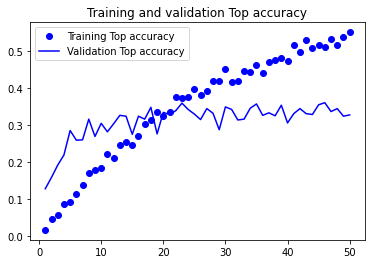

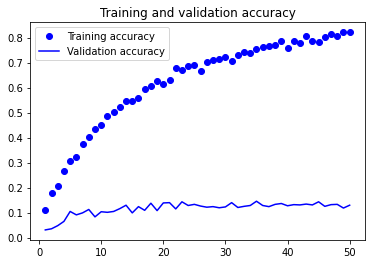

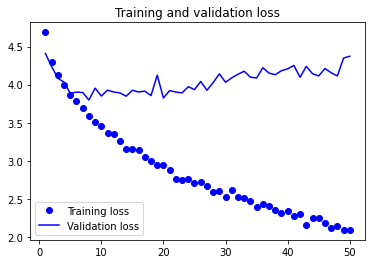

In [ ]:
acc_top = history.history['top_k_categorical_accuracy']
val_acc_top = history.history['val_top_k_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
acc_top = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc_top, 'bo', label='Training Top accuracy')
plt.plot(epochs, val_acc_top, 'b', label='Validation Top accuracy')
plt.title('Training and validation Top accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


## Probando otro método de preprocesamiento - class weight

Otras de las técnicas que se implementaron para ver si se obtenían modelos con mejores resultados, fue en lugar de balancear todas las clases, asignarles un peso diferente de acuerdo al número de observaciones dentro de cada directorio. Es decir, a las clases con menos imágenes se les dio un mayor peso, mientras que a las clases con más imágenes se les asignó un menor peso. 

In [ ]:
## Se establece la ruta en donde se tiene las imágenes originales
carpeta_train = "/Users/kls/Downloads/train_images"
carpeta_train

'/Users/kls/Downloads/train_images'

In [ ]:
## Se listan el total de archivos dentro la carpeta principal
carpetas = os.listdir(carpeta_train)

## Se elimina el archivo '.DS_Store' del directorio 
#carpetas.remove('.DS_Store')
len(carpetas)

3116

In [ ]:
## Se realiza el split de los datos en carpeta de train y validación
proporcion = 0.2
carpeta_train = "/Users/kls/Downloads/train_images"
carpeta_validation = "/Users/kls/Downloads/validation_images"

In [ ]:
train_validation_split(proporcion, carpeta_train, carpeta_validation)

************************
 Archivos restablecidos
************************
************************
 Split realizado 
************************


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
## Se define el tamaño de las imágenes, así como el tamaño del batch del set de entrenamiento
train_generator = train_datagen.flow_from_directory(carpeta_train, 
                                                    target_size = (28, 28),
                                                    batch_size=12,
                                                    save_format='jpg')

Found 37297 images belonging to 3116 classes.


In [ ]:
## Se define el tamaño de las imágenes, así como el tamaño del batch del set de validación
validation_generator = validation_datagen.flow_from_directory(carpeta_validation,
                                                    target_size = (28,28),
                                                    batch_size=11,
                                                    save_format='jpg')

Found 7406 images belonging to 3116 classes.


### Calculando pesos de las clases

Con la función compute_class_weight se asignaron pesos a cada clase de forma que el entrenamiento estuviera balanceado a pesar de que se tengan muchas imagenes en algunas clases y muy pocas en otras. Es decir, a aquellas clases con menos datos se le asignaron pesos mayores, y a las que tienen más se le asignaron pesos más bajos. 

In [ ]:
sklearn_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), 
    y=train_generator.classes)

In [ ]:
sklearn_weights = dict(enumerate(sklearn_weights))

En este diccionario podemos ver cómo ahora tenemos un peso asignado para cada una de las 3116 clases. 

In [ ]:
sklearn_weights

{0: 2.9923780487804876,
 1: 1.7099303135888502,
 2: 2.9923780487804876,
 3: 0.8549651567944251,
 4: 2.9923780487804876,
 5: 0.7480945121951219,
 6: 0.9207317073170732,
 7: 2.9923780487804876,
 8: 0.7480945121951219,
 9: 0.7480945121951219,
 10: 0.9207317073170732,
 11: 0.36271249076127127,
 12: 1.1969512195121952,
 13: 1.7099303135888502,
 14: 0.7480945121951219,
 15: 0.38611329661683713,
 16: 0.0374047256097561,
 17: 2.9923780487804876,
 18: 1.7099303135888502,
 19: 0.7480945121951219,
 20: 1.4961890243902438,
 21: 1.7099303135888502,
 22: 2.9923780487804876,
 23: 0.9974593495934959,
 24: 1.7099303135888502,
 25: 2.9923780487804876,
 26: 0.5204135737009544,
 27: 1.7099303135888502,
 28: 2.9923780487804876,
 29: 0.9207317073170732,
 30: 1.7099303135888502,
 31: 1.7099303135888502,
 32: 0.7480945121951219,
 33: 1.7099303135888502,
 34: 0.2301829268292683,
 35: 2.9923780487804876,
 36: 1.7099303135888502,
 37: 0.9207317073170732,
 38: 0.6649728997289973,
 39: 0.2301829268292683,
 40: 0.9

## Nuevos modelos

Con este preprocesamiento, se probaron las arquitecturas que se habían utilizado anteriormente. 

### Modelo 1

In [ ]:
model = models.Sequential([
                          Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3),kernel_initializer='he_uniform'), 
                          MaxPooling2D((2, 2)),
                          BatchNormalization(),
                          Flatten(), 
                          Dense(1000, activation='relu',kernel_initializer='he_uniform'), 
                          BatchNormalization(),
                          Dense(3116, activation='softmax')
                          ])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              5409000   
                                                                 
 batch_normalization_3 (Batc  (None, 1000)            

In [ ]:
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
model.compile(loss='CategoricalCrossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=[metric,'acc'])

Durante el entrenamiento se le asigan nuestro diccionario de clases al parámetro "class_weight"

In [ ]:
history = model.fit(train_generator,epochs=50,class_weight=sklearn_weights,validation_data=validation_generator,steps_per_epoch=100,validation_steps=100)

Epoch 1/50
100/100 [==============================] - 42s 422ms/step - loss: 5.6061 - top_k_categorical_accuracy: 0.2300 - acc: 0.1700 - val_loss: 9.0900 - val_top_k_categorical_accuracy: 0.0264 - val_acc: 0.0109
Epoch 2/50
100/100 [==============================] - 40s 399ms/step - loss: 5.4267 - top_k_categorical_accuracy: 0.2350 - acc: 0.1533 - val_loss: 8.6666 - val_top_k_categorical_accuracy: 0.0218 - val_acc: 0.0073
Epoch 3/50
100/100 [==============================] - 41s 410ms/step - loss: 5.4082 - top_k_categorical_accuracy: 0.2683 - acc: 0.1908 - val_loss: 9.0788 - val_top_k_categorical_accuracy: 0.0155 - val_acc: 0.0055
Epoch 4/50
100/100 [==============================] - 40s 400ms/step - loss: 5.1412 - top_k_categorical_accuracy: 0.2808 - acc: 0.2033 - val_loss: 8.6901 - val_top_k_categorical_accuracy: 0.0245 - val_acc: 0.0073
Epoch 5/50
100/100 [==============================] - 40s 403ms/step - loss: 5.1173 - top_k_categorical_accuracy: 0.2867 - acc: 0.2183 - val_loss: 8

100/100 [==============================] - 40s 399ms/step - loss: 2.8634 - top_k_categorical_accuracy: 0.5067 - acc: 0.4108 - val_loss: 9.0816 - val_top_k_categorical_accuracy: 0.0718 - val_acc: 0.0336
Epoch 40/50
100/100 [==============================] - 40s 404ms/step - loss: 2.7111 - top_k_categorical_accuracy: 0.5433 - acc: 0.4508 - val_loss: 8.7773 - val_top_k_categorical_accuracy: 0.0645 - val_acc: 0.0418
Epoch 41/50
100/100 [==============================] - 39s 397ms/step - loss: 2.8331 - top_k_categorical_accuracy: 0.5175 - acc: 0.4375 - val_loss: 8.8356 - val_top_k_categorical_accuracy: 0.0645 - val_acc: 0.0318
Epoch 42/50
100/100 [==============================] - 40s 399ms/step - loss: 2.7625 - top_k_categorical_accuracy: 0.5425 - acc: 0.4442 - val_loss: 8.7542 - val_top_k_categorical_accuracy: 0.0555 - val_acc: 0.0345
Epoch 43/50
100/100 [==============================] - 41s 411ms/step - loss: 2.6293 - top_k_categorical_accuracy: 0.5458 - acc: 0.4592 - val_loss: 8.6696 -

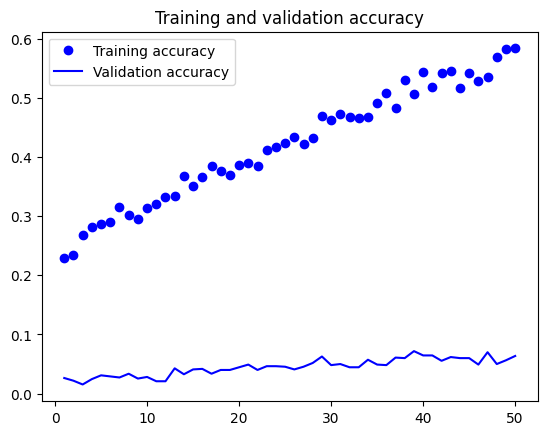

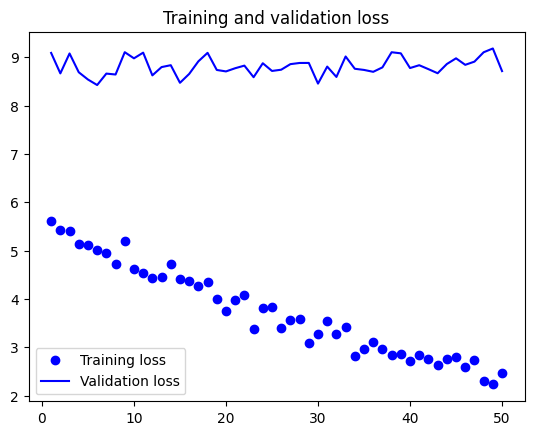

In [ ]:
acc = history.history['top_k_categorical_accuracy']
val_acc = history.history['val_top_k_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Modelo 2

In [ ]:
model2 = models.Sequential([
                          Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3),kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(l=0.01)), 
                          MaxPooling2D((2, 2)),
                          BatchNormalization(),
                          Flatten(),
                          Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l=0.1)), 
                          BatchNormalization(),
                          Dense(3116, activation='softmax')
                          ])

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               2769408   
                                                                 
 batch_normalization_5 (Batc  (None, 512)             

In [ ]:
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
model2.compile(loss='CategoricalCrossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=[metric,'acc'])

In [ ]:
history= model2.fit(train_generator, steps_per_epoch=100, epochs=50,class_weight=sklearn_weights, validation_data=validation_generator, validation_steps=70)

Epoch 1/50
100/100 [==============================] - 37s 361ms/step - loss: 39.1637 - top_k_categorical_accuracy: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 13.3976 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 35s 350ms/step - loss: 12.8267 - top_k_categorical_accuracy: 0.0042 - acc: 0.0025 - val_loss: 12.7744 - val_top_k_categorical_accuracy: 0.0013 - val_acc: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 33s 328ms/step - loss: 13.5127 - top_k_categorical_accuracy: 0.0042 - acc: 0.0017 - val_loss: 13.1460 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 4/50
100/100 [==============================] - 35s 356ms/step - loss: 13.6246 - top_k_categorical_accuracy: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 13.7064 - val_top_k_categorical_accuracy: 0.0013 - val_acc: 0.0000e+00
Epoch 5/50
100/100 [==============================] - 34s 342ms/step - loss: 12.8199 - top_k_categor

100/100 [==============================] - 34s 341ms/step - loss: 8.7399 - top_k_categorical_accuracy: 0.0033 - acc: 0.0017 - val_loss: 9.2617 - val_top_k_categorical_accuracy: 0.0013 - val_acc: 0.0000e+00
Epoch 38/50
100/100 [==============================] - 35s 351ms/step - loss: 8.6469 - top_k_categorical_accuracy: 8.3333e-04 - acc: 0.0000e+00 - val_loss: 9.2007 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 39/50
100/100 [==============================] - 34s 342ms/step - loss: 8.6365 - top_k_categorical_accuracy: 0.0050 - acc: 0.0000e+00 - val_loss: 8.8684 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 40/50
100/100 [==============================] - 34s 344ms/step - loss: 8.3285 - top_k_categorical_accuracy: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 8.6856 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 41/50
100/100 [==============================] - 34s 338ms/step - loss: 8.5351 - top_k_categorical_acc

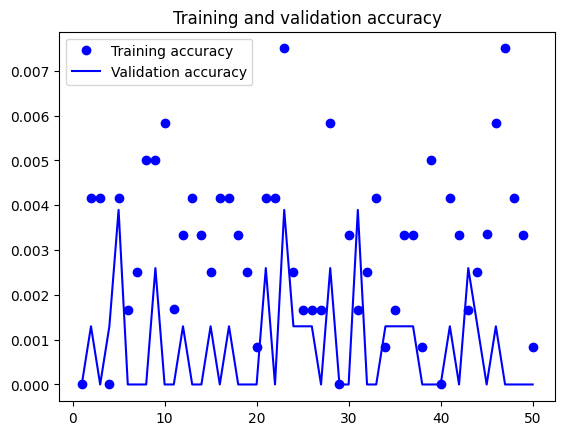

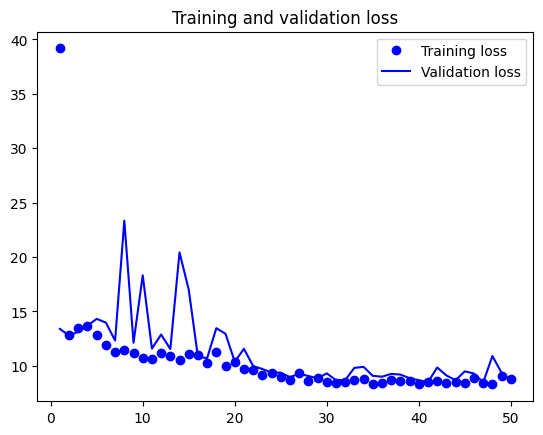

In [ ]:
acc = history.history['top_k_categorical_accuracy']
val_acc = history.history['val_top_k_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Modelo 3

In [ ]:
model3 = models.Sequential([
                          Conv2D(32, (2, 2), activation='relu', input_shape=(28, 28, 3),kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l=0.01)), 
                          MaxPooling2D((2, 2)),
                          Dropout(0.4),
                          BatchNormalization(),
                          Flatten(), 
                          Dense(5, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l=0.01)), 
                          Dropout(0.2),
                          Dense(3116, activation='softmax')
                          ])

In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 27, 27, 32)        416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_3 (Flatten)         (None, 5408)              0         
                                                                 
 dense_6 (Dense)             (None, 5)                

In [ ]:
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=150)
model3.compile(loss='CategoricalCrossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=metric)

In [ ]:
history = model3.fit(train_generator, steps_per_epoch=100, epochs=50,class_weight=sklearn_weights,validation_data=validation_generator, validation_steps=80)

Epoch 1/50
100/100 [==============================] - 35s 347ms/step - loss: 8.8419 - top_k_categorical_accuracy: 0.0533 - val_loss: 8.5989 - val_top_k_categorical_accuracy: 0.0420
Epoch 2/50
100/100 [==============================] - 35s 349ms/step - loss: 8.3008 - top_k_categorical_accuracy: 0.0550 - val_loss: 8.4208 - val_top_k_categorical_accuracy: 0.0250
Epoch 3/50
100/100 [==============================] - 34s 343ms/step - loss: 8.2349 - top_k_categorical_accuracy: 0.0408 - val_loss: 8.3021 - val_top_k_categorical_accuracy: 0.0273
Epoch 4/50
100/100 [==============================] - 34s 337ms/step - loss: 8.2306 - top_k_categorical_accuracy: 0.0475 - val_loss: 8.2247 - val_top_k_categorical_accuracy: 0.0284
Epoch 5/50
100/100 [==============================] - 34s 338ms/step - loss: 8.3733 - top_k_categorical_accuracy: 0.0350 - val_loss: 8.1773 - val_top_k_categorical_accuracy: 0.0205
Epoch 6/50
100/100 [==============================] - 32s 321ms/step - loss: 8.5007 - top_k_cat

100/100 [==============================] - 34s 341ms/step - loss: 8.0052 - top_k_categorical_accuracy: 0.0550 - val_loss: 8.0498 - val_top_k_categorical_accuracy: 0.0284
Epoch 47/50
100/100 [==============================] - 34s 339ms/step - loss: 8.0553 - top_k_categorical_accuracy: 0.0575 - val_loss: 8.0565 - val_top_k_categorical_accuracy: 0.0250
Epoch 48/50
100/100 [==============================] - 34s 338ms/step - loss: 8.0976 - top_k_categorical_accuracy: 0.0458 - val_loss: 8.0410 - val_top_k_categorical_accuracy: 0.0341
Epoch 49/50
100/100 [==============================] - 35s 350ms/step - loss: 8.1111 - top_k_categorical_accuracy: 0.0458 - val_loss: 8.0575 - val_top_k_categorical_accuracy: 0.0375
Epoch 50/50
100/100 [==============================] - 34s 343ms/step - loss: 7.7790 - top_k_categorical_accuracy: 0.0592 - val_loss: 8.1565 - val_top_k_categorical_accuracy: 0.0182


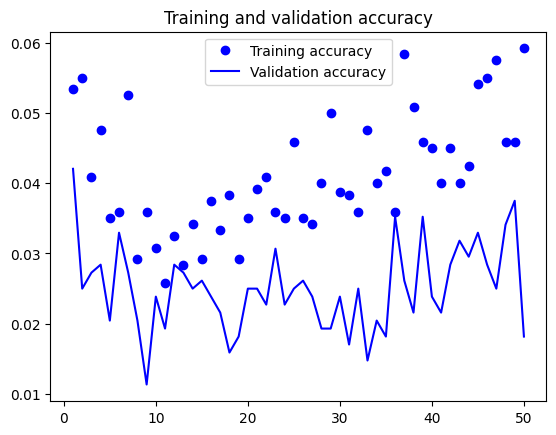

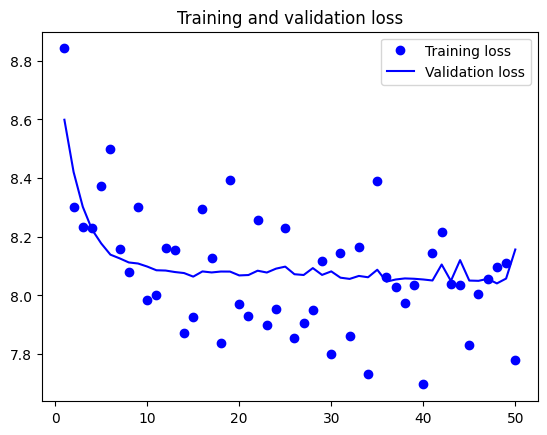

In [ ]:
acc = history.history['top_k_categorical_accuracy']
val_acc = history.history['val_top_k_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Transfer learning con método de preprocesamiento de class_weight

Finalmente, otra de las técnicas implementadas, fue utilizar "Trsnfer Learning". Esto quiere decir que se importaron modelos ya entrenados que tuvieron muy buenos resultados en sus respectivos problemas, y adaptar un poco la parte convolucional al contexto que se está trabajando. De esta manera es posible incrementar el número de parámetros a calcular, pero sin sacrificar tanto poder computacional, ya que gran parte del modelo ya está entrenada. 

Cabe mencionar que el modelo que se importó corresponde a "InceptionResNetV2".

### Modelo 1

In [ ]:
## Se define el tamaño de las imágenes, así como el tamaño del batch del set de entrenamiento
train_generator = train_datagen.flow_from_directory(carpeta_train, 
                                                    target_size = (224, 224),
                                                    batch_size=12,
                                                    save_format='jpg')

Found 37297 images belonging to 3116 classes.


In [ ]:
## Se define el tamaño de las imágenes, así como el tamaño del batch del set de validación
validation_generator = validation_datagen.flow_from_directory(carpeta_validation,
                                                    target_size = (224,224),
                                                    batch_size=11,
                                                    save_format='jpg')

Found 7406 images belonging to 3116 classes.


In [ ]:
next(train_generator)[0].shape

(12, 224, 224, 3)

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(224,224,3))

base_model.trainable=False

In [ ]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3077 (Conv2D)           (None, 111, 111, 32  864         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_3120 (Batc  (None, 111, 111, 32  96         ['conv2d_3077[0][0]']            
 hNormalization)                )                                               

                                                                                                  
 conv2d_3084 (Conv2D)           (None, 25, 25, 64)   76800       ['activation_3051[0][0]']        
                                                                                                  
 conv2d_3087 (Conv2D)           (None, 25, 25, 96)   82944       ['activation_3054[0][0]']        
                                                                                                  
 conv2d_3088 (Conv2D)           (None, 25, 25, 64)   12288       ['average_pooling2d_15[0][0]']   
                                                                                                  
 batch_normalization_3125 (Batc  (None, 25, 25, 96)  288         ['conv2d_3082[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 batch_nor

                                                                                                  
 block35_1_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_3057[0][0]',        
                                                                  'activation_3059[0][0]',        
                                                                  'activation_3062[0][0]']        
                                                                                                  
 block35_1_conv (Conv2D)        (None, 25, 25, 320)  41280       ['block35_1_mixed[0][0]']        
                                                                                                  
 block35_1 (Lambda)             (None, 25, 25, 320)  0           ['mixed_5b[0][0]',               
                                                                  'block35_1_conv[0][0]']         
                                                                                                  
 block35_1

 batch_normalization_3145 (Batc  (None, 25, 25, 32)  96          ['conv2d_3102[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 batch_normalization_3148 (Batc  (None, 25, 25, 48)  144         ['conv2d_3105[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3070 (Activation)   (None, 25, 25, 32)   0           ['batch_normalization_3145[0][0]'
                                                                 ]                                
                                                                                                  
 activation_3073 (Activation)   (None, 25, 25, 48)   0           ['batch_normalization_3148[0][0]'
          

 batch_normalization_3155 (Batc  (None, 25, 25, 64)  192         ['conv2d_3112[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3075 (Activation)   (None, 25, 25, 32)   0           ['batch_normalization_3150[0][0]'
                                                                 ]                                
                                                                                                  
 activation_3077 (Activation)   (None, 25, 25, 32)   0           ['batch_normalization_3152[0][0]'
                                                                 ]                                
                                                                                                  
 activation_3080 (Activation)   (None, 25, 25, 64)   0           ['batch_normalization_3155[0][0]'
          

                                                                                                  
 batch_normalization_3165 (Batc  (None, 25, 25, 32)  96          ['conv2d_3122[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3090 (Activation)   (None, 25, 25, 32)   0           ['batch_normalization_3165[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_3120 (Conv2D)           (None, 25, 25, 32)   10240       ['block35_5_ac[0][0]']           
                                                                                                  
 conv2d_3123 (Conv2D)           (None, 25, 25, 48)   13824       ['activation_3090[0][0]']        
          

                                                                                                  
 conv2d_3127 (Conv2D)           (None, 25, 25, 32)   9216        ['activation_3094[0][0]']        
                                                                                                  
 conv2d_3130 (Conv2D)           (None, 25, 25, 64)   27648       ['activation_3097[0][0]']        
                                                                                                  
 batch_normalization_3168 (Batc  (None, 25, 25, 32)  96          ['conv2d_3125[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 batch_normalization_3170 (Batc  (None, 25, 25, 32)  96          ['conv2d_3127[0][0]']            
 hNormalization)                                                                                  
          

                                                                  'activation_3101[0][0]',        
                                                                  'activation_3104[0][0]']        
                                                                                                  
 block35_8_conv (Conv2D)        (None, 25, 25, 320)  41280       ['block35_8_mixed[0][0]']        
                                                                                                  
 block35_8 (Lambda)             (None, 25, 25, 320)  0           ['block35_7_ac[0][0]',           
                                                                  'block35_8_conv[0][0]']         
                                                                                                  
 block35_8_ac (Activation)      (None, 25, 25, 320)  0           ['block35_8[0][0]']              
                                                                                                  
 conv2d_31

                                                                                                  
 batch_normalization_3190 (Batc  (None, 25, 25, 48)  144         ['conv2d_3147[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3112 (Activation)   (None, 25, 25, 32)   0           ['batch_normalization_3187[0][0]'
                                                                 ]                                
                                                                                                  
 activation_3115 (Activation)   (None, 25, 25, 48)   0           ['batch_normalization_3190[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_31

                                                                                                  
 conv2d_3154 (Conv2D)           (None, 12, 12, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_normalization_3197 (Batc  (None, 12, 12, 128)  384        ['conv2d_3154[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3122 (Activation)   (None, 12, 12, 128)  0           ['batch_normalization_3197[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_3155 (Conv2D)           (None, 12, 12, 160)  143360      ['activation_3122[0][0]']        
          

 block17_2 (Lambda)             (None, 12, 12, 1088  0           ['block17_1_ac[0][0]',           
                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 12, 12, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_3162 (Conv2D)           (None, 12, 12, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_3205 (Batc  (None, 12, 12, 128)  384        ['conv2d_3162[0][0]']            
 hNormalization)                                                                                  
          

                                                                  'activation_3136[0][0]']        
                                                                                                  
 block17_4_conv (Conv2D)        (None, 12, 12, 1088  418880      ['block17_4_mixed[0][0]']        
                                )                                                                 
                                                                                                  
 block17_4 (Lambda)             (None, 12, 12, 1088  0           ['block17_3_ac[0][0]',           
                                )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 12, 12, 1088  0           ['block17_4[0][0]']              
                                )                                                                 
          

                                                                                                  
 activation_3144 (Activation)   (None, 12, 12, 192)  0           ['batch_normalization_3219[0][0]'
                                                                 ]                                
                                                                                                  
 block17_6_mixed (Concatenate)  (None, 12, 12, 384)  0           ['activation_3141[0][0]',        
                                                                  'activation_3144[0][0]']        
                                                                                                  
 block17_6_conv (Conv2D)        (None, 12, 12, 1088  418880      ['block17_6_mixed[0][0]']        
                                )                                                                 
                                                                                                  
 block17_6

 batch_normalization_3227 (Batc  (None, 12, 12, 192)  576        ['conv2d_3184[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3149 (Activation)   (None, 12, 12, 192)  0           ['batch_normalization_3224[0][0]'
                                                                 ]                                
                                                                                                  
 activation_3152 (Activation)   (None, 12, 12, 192)  0           ['batch_normalization_3227[0][0]'
                                                                 ]                                
                                                                                                  
 block17_8_mixed (Concatenate)  (None, 12, 12, 384)  0           ['activation_3149[0][0]',        
          

 conv2d_3192 (Conv2D)           (None, 12, 12, 192)  215040      ['activation_3159[0][0]']        
                                                                                                  
 batch_normalization_3232 (Batc  (None, 12, 12, 192)  576        ['conv2d_3189[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 batch_normalization_3235 (Batc  (None, 12, 12, 192)  576        ['conv2d_3192[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3157 (Activation)   (None, 12, 12, 192)  0           ['batch_normalization_3232[0][0]'
                                                                 ]                                
          

 activation_3167 (Activation)   (None, 12, 12, 160)  0           ['batch_normalization_3242[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_3197 (Conv2D)           (None, 12, 12, 192)  208896      ['block17_11_ac[0][0]']          
                                                                                                  
 conv2d_3200 (Conv2D)           (None, 12, 12, 192)  215040      ['activation_3167[0][0]']        
                                                                                                  
 batch_normalization_3240 (Batc  (None, 12, 12, 192)  576        ['conv2d_3197[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 batch_nor

 conv2d_3207 (Conv2D)           (None, 12, 12, 160)  143360      ['activation_3174[0][0]']        
                                                                                                  
 batch_normalization_3250 (Batc  (None, 12, 12, 160)  480        ['conv2d_3207[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3175 (Activation)   (None, 12, 12, 160)  0           ['batch_normalization_3250[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_3205 (Conv2D)           (None, 12, 12, 192)  208896      ['block17_13_ac[0][0]']          
                                                                                                  
 conv2d_32

 hNormalization)                                                                                  
                                                                                                  
 activation_3182 (Activation)   (None, 12, 12, 128)  0           ['batch_normalization_3257[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_3215 (Conv2D)           (None, 12, 12, 160)  143360      ['activation_3182[0][0]']        
                                                                                                  
 batch_normalization_3258 (Batc  (None, 12, 12, 160)  480        ['conv2d_3215[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_3222 (Conv2D)           (None, 12, 12, 128)  139264      ['block17_17_ac[0][0]']          
                                                                                                  
 batch_normalization_3265 (Batc  (None, 12, 12, 128)  384        ['conv2d_3222[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3190 (Activation)   (None, 12, 12, 128)  0           ['batch_normalization_3265[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_32

                                                                                                  
 block17_19 (Lambda)            (None, 12, 12, 1088  0           ['block17_18_ac[0][0]',          
                                )                                 'block17_19_conv[0][0]']        
                                                                                                  
 block17_19_ac (Activation)     (None, 12, 12, 1088  0           ['block17_19[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_3230 (Conv2D)           (None, 12, 12, 128)  139264      ['block17_19_ac[0][0]']          
                                                                                                  
 batch_normalization_3273 (Batc  (None, 12, 12, 128)  384        ['conv2d_3230[0][0]']            
 hNormaliz

 conv2d_3234 (Conv2D)           (None, 5, 5, 384)    884736      ['activation_3201[0][0]']        
                                                                                                  
 conv2d_3236 (Conv2D)           (None, 5, 5, 288)    663552      ['activation_3203[0][0]']        
                                                                                                  
 conv2d_3239 (Conv2D)           (None, 5, 5, 320)    829440      ['activation_3206[0][0]']        
                                                                                                  
 batch_normalization_3277 (Batc  (None, 5, 5, 384)   1152        ['conv2d_3234[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 batch_normalization_3279 (Batc  (None, 5, 5, 288)   864         ['conv2d_3236[0][0]']            
 hNormaliz

                                                                                                  
 batch_normalization_3289 (Batc  (None, 5, 5, 224)   672         ['conv2d_3246[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3214 (Activation)   (None, 5, 5, 224)    0           ['batch_normalization_3289[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_3244 (Conv2D)           (None, 5, 5, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_3247 (Conv2D)           (None, 5, 5, 256)    172032      ['activation_3214[0][0]']        
          

 conv2d_3254 (Conv2D)           (None, 5, 5, 224)    129024      ['activation_3221[0][0]']        
                                                                                                  
 batch_normalization_3297 (Batc  (None, 5, 5, 224)   672         ['conv2d_3254[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3222 (Activation)   (None, 5, 5, 224)    0           ['batch_normalization_3297[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_3252 (Conv2D)           (None, 5, 5, 192)    399360      ['block8_3_ac[0][0]']            
                                                                                                  
 conv2d_32

                                                                                                  
 conv2d_3262 (Conv2D)           (None, 5, 5, 224)    129024      ['activation_3229[0][0]']        
                                                                                                  
 batch_normalization_3305 (Batc  (None, 5, 5, 224)   672         ['conv2d_3262[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3230 (Activation)   (None, 5, 5, 224)    0           ['batch_normalization_3305[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_3260 (Conv2D)           (None, 5, 5, 192)    399360      ['block8_5_ac[0][0]']            
          

                                                                 ]                                
                                                                                                  
 conv2d_3270 (Conv2D)           (None, 5, 5, 224)    129024      ['activation_3237[0][0]']        
                                                                                                  
 batch_normalization_3313 (Batc  (None, 5, 5, 224)   672         ['conv2d_3270[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3238 (Activation)   (None, 5, 5, 224)    0           ['batch_normalization_3313[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_32

 activation_3245 (Activation)   (None, 5, 5, 192)    0           ['batch_normalization_3320[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_3278 (Conv2D)           (None, 5, 5, 224)    129024      ['activation_3245[0][0]']        
                                                                                                  
 batch_normalization_3321 (Batc  (None, 5, 5, 224)   672         ['conv2d_3278[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_3246 (Activation)   (None, 5, 5, 224)    0           ['batch_normalization_3321[0][0]'
                                                                 ]                                
          

In [ ]:
model4 = models.Sequential([
                          base_model,
                          Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224,3),kernel_initializer='he_uniform'), 
                          MaxPooling2D((2, 2)),
                          BatchNormalization(),
                          Flatten(), 
                          Dense(1000, activation='relu',kernel_initializer='he_uniform'), 
                          BatchNormalization(),
                          Dense(3116, activation='softmax')
                          ])

In [ ]:
model4.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 conv2d_3281 (Conv2D)        (None, 3, 3, 32)          442400    
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 1, 1, 32)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_3325 (B  (None, 1, 1, 32)         128       
 atchNormalization)                                              
                                                                 
 flatten_40 (Flatten)        (None, 32)                0         
                                                     

In [ ]:
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
model4.compile(loss='CategoricalCrossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=[metric,'acc'])

In [ ]:
history = model4.fit(train_generator, steps_per_epoch=100, epochs=30, class_weight=sklearn_weights,validation_data=validation_generator, validation_steps=100)

Epoch 1/30
100/100 [==============================] - 417s 4s/step - loss: 9.2657 - top_k_categorical_accuracy: 0.0025 - acc: 8.4104e-04 - val_loss: 13.5912 - val_top_k_categorical_accuracy: 0.0018 - val_acc: 0.0000e+00
Epoch 2/30
100/100 [==============================] - 385s 4s/step - loss: 10.3919 - top_k_categorical_accuracy: 8.3333e-04 - acc: 8.3333e-04 - val_loss: 11.2007 - val_top_k_categorical_accuracy: 0.0018 - val_acc: 9.0909e-04
Epoch 3/30
100/100 [==============================] - 381s 4s/step - loss: 9.3180 - top_k_categorical_accuracy: 0.0042 - acc: 8.3333e-04 - val_loss: 8.9673 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 4/30
100/100 [==============================] - 386s 4s/step - loss: 8.9318 - top_k_categorical_accuracy: 0.0075 - acc: 0.0000e+00 - val_loss: 8.4874 - val_top_k_categorical_accuracy: 0.0027 - val_acc: 0.0000e+00
Epoch 5/30
100/100 [==============================] - 483s 5s/step - loss: 8.3900 - top_k_categorical_accuracy: 0

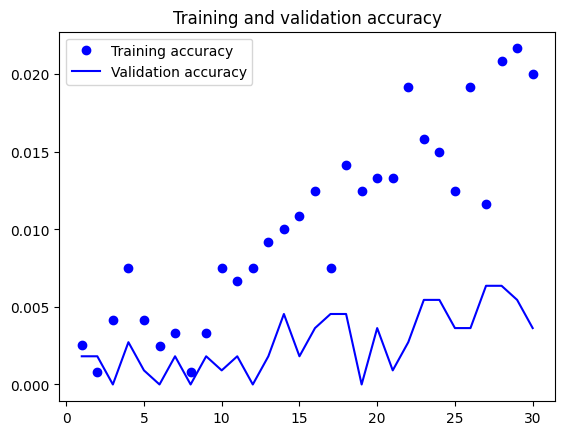

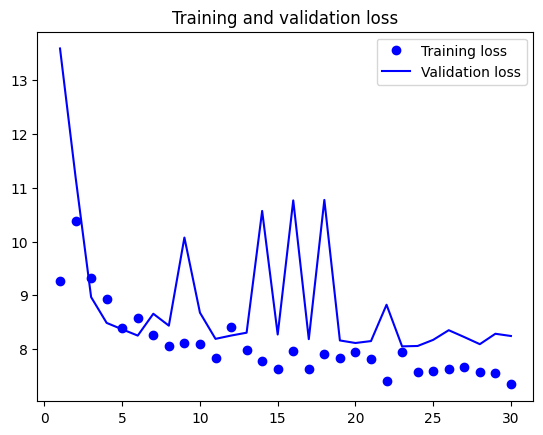

In [ ]:
acc = history.history['top_k_categorical_accuracy']
val_acc = history.history['val_top_k_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Modelo 2

In [ ]:
model5 = models.Sequential([base_model,
                          Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3),kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(l=0.01)), 
                          MaxPooling2D((2, 2)),
                          BatchNormalization(),
                          Flatten(),
                          Dense(128, activation='relu'), 
                          BatchNormalization(),
                          Dense(3116, activation='softmax')
                          ])

In [ ]:
model5.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 conv2d_3282 (Conv2D)        (None, 3, 3, 32)          442400    
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 1, 1, 32)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_3327 (B  (None, 1, 1, 32)         128       
 atchNormalization)                                              
                                                                 
 flatten_41 (Flatten)        (None, 32)                0         
                                                     

In [ ]:
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
model5.compile(loss='CategoricalCrossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=[metric,'acc'])

In [ ]:
history= model5.fit(train_generator, steps_per_epoch=100, epochs=30,class_weight=sklearn_weights, validation_data=validation_generator, validation_steps=70)

Epoch 1/30
100/100 [==============================] - 311s 3s/step - loss: 8.8469 - top_k_categorical_accuracy: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 9.1055 - val_top_k_categorical_accuracy: 0.0026 - val_acc: 0.0013
Epoch 2/30
100/100 [==============================] - 281s 3s/step - loss: 9.3634 - top_k_categorical_accuracy: 0.0050 - acc: 8.3333e-04 - val_loss: 9.1731 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/30
100/100 [==============================] - 276s 3s/step - loss: 8.9928 - top_k_categorical_accuracy: 0.0042 - acc: 8.3333e-04 - val_loss: 8.8391 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 4/30
100/100 [==============================] - 276s 3s/step - loss: 9.0648 - top_k_categorical_accuracy: 0.0025 - acc: 8.3333e-04 - val_loss: 11.3572 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 5/30
100/100 [==============================] - 276s 3s/step - loss: 8.6376 - top_k_categorical_accuracy:

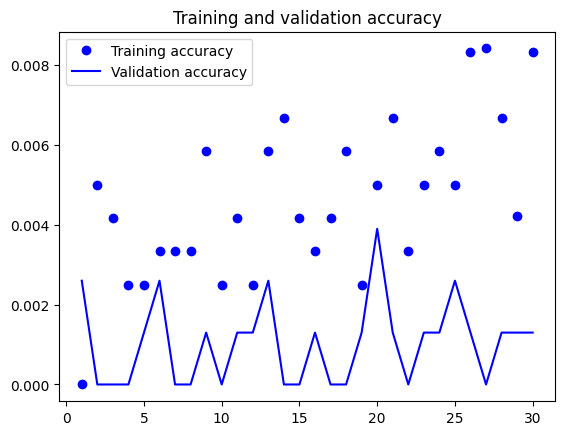

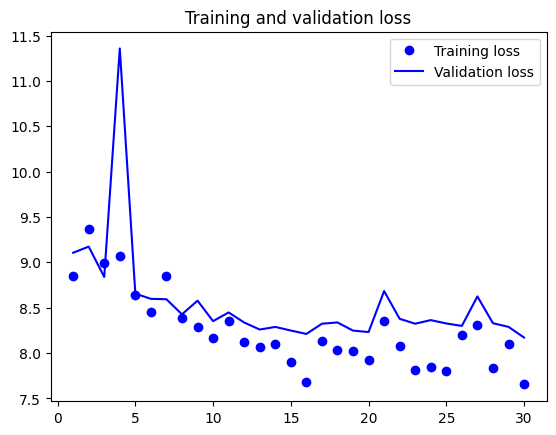

In [ ]:
acc = history.history['top_k_categorical_accuracy']
val_acc = history.history['val_top_k_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Modelo 3

In [ ]:
model6 = models.Sequential([base_model,
                          Conv2D(32, (2, 2), activation='relu', input_shape=(224, 224, 3),kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l=0.01)), 
                          MaxPooling2D((2, 2)),
                          Dropout(0.4),
                          #BatchNormalization(),
                          Flatten(), 
                          #Dense(128, activation='relu',kernel_initializer='he_uniform'), 
                          Dropout(0.2),
                          Dense(3116, activation='softmax')
                          ])

In [ ]:
model6.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 conv2d_3284 (Conv2D)        (None, 4, 4, 32)          196640    
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 2, 2, 32)         0         
 ng2D)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 32)          0         
                                                                 
 flatten_43 (Flatten)        (None, 128)               0         
                                                                 
 dropout_5 (Dropout)         (None, 128)             

In [ ]:
metric = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
model6.compile(loss='CategoricalCrossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=[metric,'acc'])

In [ ]:
history = model6.fit(train_generator, steps_per_epoch=100, epochs=10, class_weight=sklearn_weights,validation_data=validation_generator, validation_steps=100)

Epoch 1/10
100/100 [==============================] - 334s 3s/step - loss: 8.7240 - top_k_categorical_accuracy: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 8.5811 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 329s 3s/step - loss: 8.4535 - top_k_categorical_accuracy: 8.3333e-04 - acc: 0.0000e+00 - val_loss: 8.4028 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 329s 3s/step - loss: 8.5060 - top_k_categorical_accuracy: 0.0017 - acc: 0.0000e+00 - val_loss: 8.2831 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 330s 3s/step - loss: 8.1935 - top_k_categorical_accuracy: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 8.2033 - val_top_k_categorical_accuracy: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 329s 3s/step - loss: 8.5120 - top_k_catego

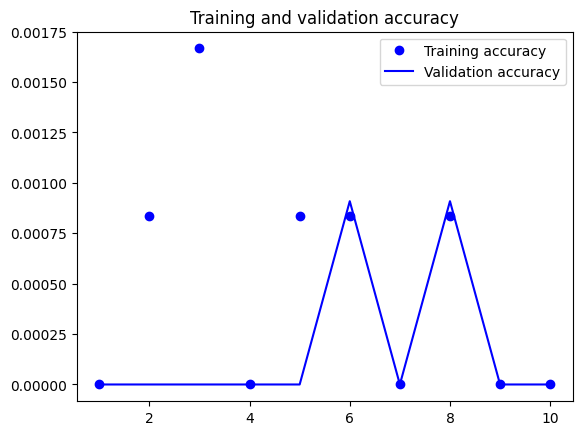

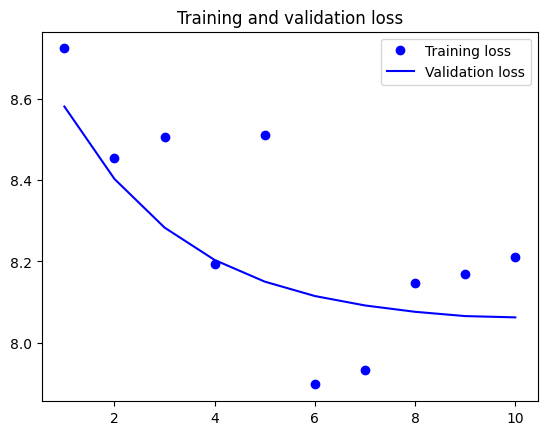

In [ ]:
acc = history.history['top_k_categorical_accuracy']
val_acc = history.history['val_top_k_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()